In [1]:
import os
import sys; sys.path.append("../") # For relative imports

import pandas as pd

from utils.conformal_utils import *
from utils.experiment_utils import get_inputs_folder, get_outputs_folder, get_figs_folder

%load_ext autoreload
%autoreload 2

plt.rcParams.update({
    'font.size': 16,        # base font size
    'axes.titlesize': 18,   # subplot titles
    'axes.labelsize': 16,   # x/y labels
    'legend.fontsize': 16,  # legend text
    'xtick.labelsize': 16,  # tick labels
    'ytick.labelsize': 16,

})
# use tex with matplotlib
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

dataset_names = {
    "plantnet": "Pl@ntNet-300K",
    "plantnet-trunc": "Pl@ntNet-300K (truncated)",
    "inaturalist": "iNaturalist-2018",
    "inaturalist-trunc": "iNaturalist-2018 (truncated)",
}

In [2]:
# Load in paths from folders.json
inputs_folder = get_inputs_folder()
results_folder = get_outputs_folder()
fig_folder = get_figs_folder()

In [3]:
dataset = 'plantnet'

# ------- Get data --------
cal_softmax = np.load(f'{inputs_folder}/best-{dataset}-model_cal_softmax.npy')
cal_labels = np.load(f'{inputs_folder}/best-{dataset}-model_cal_labels.npy')
test_softmax = np.load(f'{inputs_folder}/best-{dataset}-model_test_softmax.npy')
test_labels = np.load(f'{inputs_folder}/best-{dataset}-model_test_labels.npy')
print('Loaded pre-computed softmax scores')

num_classes = cal_softmax.shape[1]
print('Num classes:', num_classes)

Loaded pre-computed softmax scores
Num classes: 1081


In [4]:
def get_plantnet_at_risk_species():
    ## Identify indices of at-risk species in PlantNet-300K

    names_as_numbers_files = "../data/plantnet300K_class_idx_to_species_id.json"
    names_files = "../data/plantnet300K_species_id_2_name.json"
    status_iucn = "../data/plantnet300K_iucn_status_dict.json"
    
    names_as_numbers = json.load(open(names_as_numbers_files, "r"))
    new_names = json.load(open(names_files, "r"))
    status_iucn = json.load(open(status_iucn, "r"))
    
    df = pd.DataFrame.from_dict(names_as_numbers, orient="index", columns=["species_id"])
    df = df.reset_index()
    df = df.rename(columns={"index": "class_id"})
    
    # df["species_id"] = df["species_id"].astype(str)
    df["class_id"] = df["class_id"].astype(int)
    df["species_name"] = df["species_id"].map(new_names)
    # df = df.set_index("class_id")
    
    
    # create a new dataframe with the iucn status with the species_id and the iucn status
    df_iucn = pd.DataFrame.from_dict(status_iucn, orient="index", columns=["iucn_status"])
    df["iucn_status"] = "Not Evaluated"
    for idx, specie in enumerate(df["species_name"].values):
        if specie in df_iucn.index:
            df.loc[idx, "iucn_status"] = df_iucn.loc[specie, "iucn_status"]

    print('Number of each IUCN category:', df['iucn_status'].value_counts())
    at_risk_codes = ['EN', 'VU', 'NT', 'CR', 'LR/nt', 'LR/lc', 'LR/cd']
    print(f'We consider {at_risk_codes} as at-risk')
    at_risk_class_ids = np.array(df['class_id'][df['iucn_status'].isin(at_risk_codes)])

    print('At-risk species:', at_risk_class_ids, f'({len(at_risk_class_ids)} total)')
    return at_risk_class_ids

at_risk_species = get_plantnet_at_risk_species()



Number of each IUCN category: iucn_status
Not Evaluated    812
LC               230
EN                14
VU                 9
DD                 6
NT                 4
CR                 3
LR/nt              1
LR/lc              1
LR/cd              1
Name: count, dtype: int64
We consider ['EN', 'VU', 'NT', 'CR', 'LR/nt', 'LR/lc', 'LR/cd'] as at-risk
At-risk species: [ 227  252  264  299  325  326  330  487  514  603  636  664  704  728
  799  814  821  839  842  861  864  865  873  893  911  914  975  979
 1028 1031 1045 1049 1070] (33 total)


In [5]:
%%time
train_labels_path = f'{inputs_folder}/{dataset}_train_labels.npy'
alphas = [.2, .1, .05, .01]
gammas = [2, 10, 100, 500] # scalar for upweighting at risk species

all_res = {f'{alpha=}': {} for alpha in alphas}

for score, b in zip(['softmax', 'PAS', 'WPAS', 'WPAS', 'WPAS', 'WPAS'], 
                    [None, None] + gammas):

    ## Get conformal scores
    if score == 'WPAS':
        weights = np.ones((num_classes,))
        weights[at_risk_species] = b
        weights = weights / np.sum(weights)
    else:
        weights = None
    cal_scores = get_conformal_scores(cal_softmax, score, 
                                      train_labels_path=train_labels_path, weights=weights)
    test_scores = get_conformal_scores(test_softmax, score, 
                                      train_labels_path=train_labels_path, weights=weights)

    # Run Standard CP for different alphas
    for alpha in alphas:
        standard_qhat, pred_sets, coverage_metrics, set_size_metrics = standard_conformal(cal_scores, cal_labels, 
                                                           test_scores, test_labels, alpha)
        res = {'pred_sets': pred_sets, 
               'qhat': standard_qhat,
               'coverage_metrics': coverage_metrics,
               'set_size_metrics': set_size_metrics}

        if score == 'WPAS':
            score_name = f'WPAS ($\\gamma=$ {b})'
        else:
            score_name = score
            
        all_res[f'{alpha=}'][score_name] = res
        
    

CPU times: user 13.2 s, sys: 3.03 s, total: 16.2 s
Wall time: 16.3 s


----- alpha = 0.2 -----
[softmax] avg class-cond cov for at risk species: 0.360 , for other species: 0.389
[PAS] avg class-cond cov for at risk species: 0.758 , for other species: 0.737
[WPAS ($\gamma=$ 2)] avg class-cond cov for at risk species: 0.762 , for other species: 0.737
[WPAS ($\gamma=$ 10)] avg class-cond cov for at risk species: 0.885 , for other species: 0.737
[WPAS ($\gamma=$ 100)] avg class-cond cov for at risk species: 0.950 , for other species: 0.737
[WPAS ($\gamma=$ 500)] avg class-cond cov for at risk species: 0.981 , for other species: 0.737


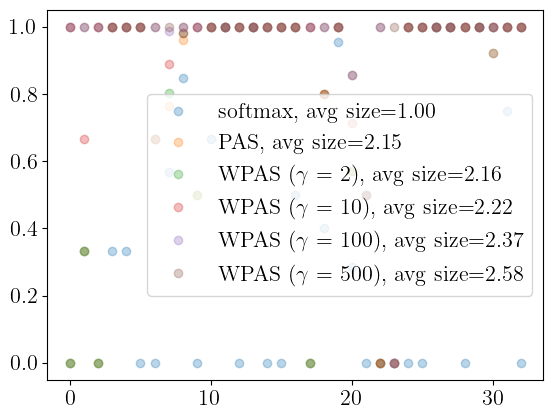

----- alpha = 0.1 -----
[softmax] avg class-cond cov for at risk species: 0.455 , for other species: 0.528
[PAS] avg class-cond cov for at risk species: 0.761 , for other species: 0.763
[WPAS ($\gamma=$ 2)] avg class-cond cov for at risk species: 0.839 , for other species: 0.763
[WPAS ($\gamma=$ 10)] avg class-cond cov for at risk species: 0.903 , for other species: 0.763
[WPAS ($\gamma=$ 100)] avg class-cond cov for at risk species: 0.950 , for other species: 0.763
[WPAS ($\gamma=$ 500)] avg class-cond cov for at risk species: 0.981 , for other species: 0.763


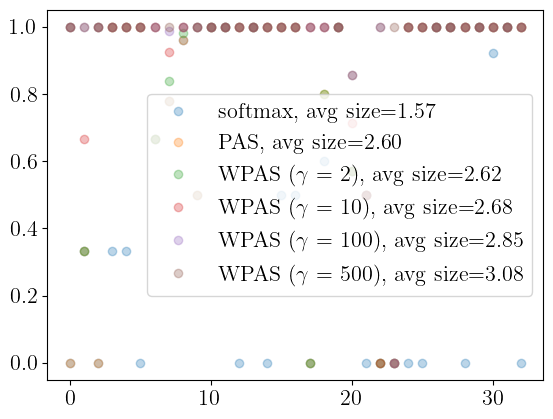

----- alpha = 0.05 -----
[softmax] avg class-cond cov for at risk species: 0.658 , for other species: 0.654
[PAS] avg class-cond cov for at risk species: 0.844 , for other species: 0.835
[WPAS ($\gamma=$ 2)] avg class-cond cov for at risk species: 0.892 , for other species: 0.835
[WPAS ($\gamma=$ 10)] avg class-cond cov for at risk species: 0.949 , for other species: 0.834
[WPAS ($\gamma=$ 100)] avg class-cond cov for at risk species: 0.981 , for other species: 0.834
[WPAS ($\gamma=$ 500)] avg class-cond cov for at risk species: 1.000 , for other species: 0.834


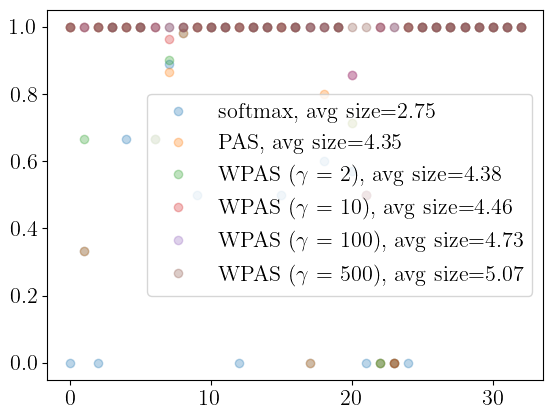

----- alpha = 0.01 -----
[softmax] avg class-cond cov for at risk species: 0.880 , for other species: 0.865
[PAS] avg class-cond cov for at risk species: 0.980 , for other species: 0.928
[WPAS ($\gamma=$ 2)] avg class-cond cov for at risk species: 0.981 , for other species: 0.928
[WPAS ($\gamma=$ 10)] avg class-cond cov for at risk species: 1.000 , for other species: 0.928
[WPAS ($\gamma=$ 100)] avg class-cond cov for at risk species: 1.000 , for other species: 0.928
[WPAS ($\gamma=$ 500)] avg class-cond cov for at risk species: 1.000 , for other species: 0.928


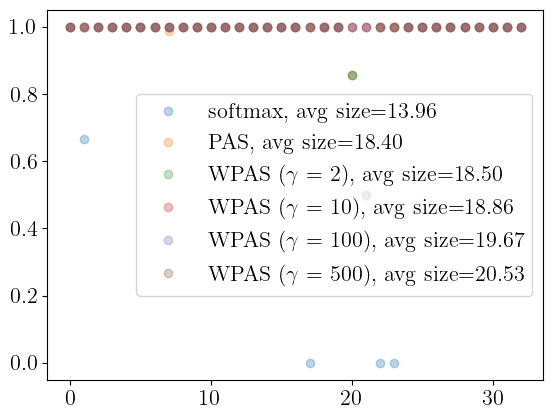

In [6]:
for alpha in alphas:
    print(f'----- alpha = {alpha} -----')
    for score in all_res[f'alpha={alphas[0]}'].keys():
        res = all_res[f'{alpha=}'][score]
        plt.plot(res['coverage_metrics']['raw_class_coverages'][at_risk_species], 'o', alpha=0.3, 
                 label=f'{score}, avg size={res['set_size_metrics']['mean']:.2f}')
        other_species = np.setdiff1d(np.arange(num_classes), at_risk_species)
        print(f'[{score}] avg class-cond cov for at risk species: {np.mean(res['coverage_metrics']['raw_class_coverages'][at_risk_species]):.3f}',
             f', for other species: {np.mean(res['coverage_metrics']['raw_class_coverages'][other_species]):.3f}')
    plt.legend()
    # plt.title(f'Average set size: {res['set_size_metrics']['mean']}')
    plt.show()

/tmp/ipykernel_4107900/2226861042.py:61: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Saved plot to /home/tding/code/clean/long-tail-conformal/figs/weighted_macro_coverage/plantnet_weighted_macro_coverage_results.pdf


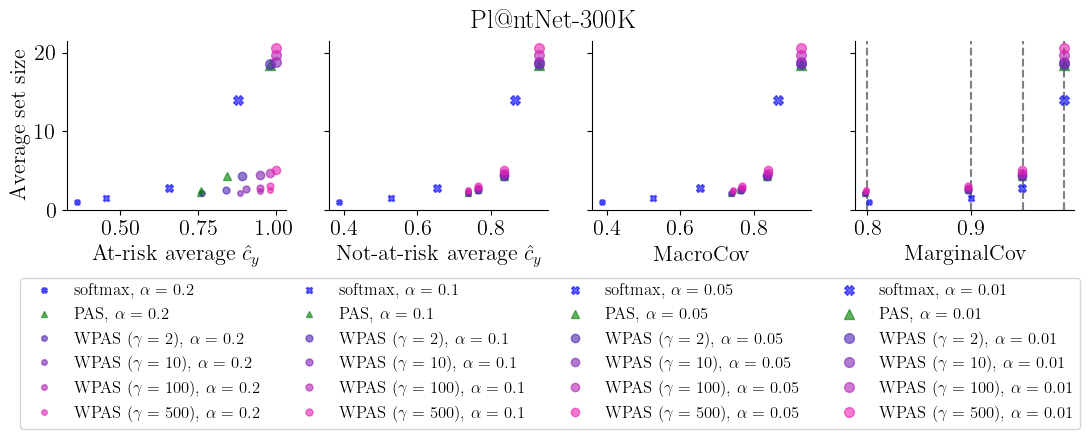

In [7]:
score_to_color = {'softmax': 'blue',
                  'PAS': 'green',
                   f'WPAS ($\\gamma=$ {gammas[0]})': (0.3, 0.13, 0.7),
                   f'WPAS ($\\gamma=$ {gammas[1]})': (0.5, 0.13, 0.7),
                   f'WPAS ($\\gamma=$ {gammas[2]})': (0.7, 0.13, 0.7),
                   f'WPAS ($\\gamma=$ {gammas[3]})': (0.9, 0.13, 0.7),
                  }

alphas = [.2, .1, .05, .01]



markersizes = [4,5,6,7]

metric_names = ['At-risk average $\\hat{c}_y$',
                'Not-at-risk average $\\hat{c}_y$',
                'MacroCov',
                'MarginalCov']
             
fig, axes = plt.subplots(1, len(metric_names), figsize=(13, 2.2), sharey=True)
for i in range(len(metric_names)):
    ax = axes[i]
    if i == 3:
        for a in alphas:
                ax.axvline(1-a, linestyle='--', color='grey')
            
    for j, alpha in enumerate(alphas):
        for score in all_res[f'alpha={alphas[0]}'].keys():
            res = all_res[f'{alpha=}'][score]

            if score == 'softmax':
                marker = 'X'
            elif score == 'PAS':
                marker = '^'
            else:
                marker = 'o'
            
            if i == 0: # Avg of at risk
                x = np.mean(res['coverage_metrics']['raw_class_coverages'][at_risk_species])
            elif i == 1: # Avg of not at risk species
                other_species = np.setdiff1d(np.arange(num_classes), at_risk_species)
                x = np.mean(res['coverage_metrics']['raw_class_coverages'][other_species])
            elif i == 2: # Macro-coverage
                x = np.mean(res['coverage_metrics']['raw_class_coverages'])
            elif i == 3: # Marginal coverage
                x = res['coverage_metrics']['marginal_cov']
                
            y = res['set_size_metrics']['mean']
           
            ax.plot(x, y, marker, alpha=0.6, markersize=markersizes[j],
                    color=score_to_color[score], label=f'{score}, $\\alpha=$ {alpha}')
            ax.spines[['right', 'top']].set_visible(False)
            # other_species = np.setdiff1d(np.arange(num_classes), at_risk_species)
            # print(f'[{score}] avg class-cond cov for at risk species: {np.mean(res['coverage_metrics']['raw_class_coverages'][at_risk_species]):.3f}',
            #      f', for other species: {np.mean(res['coverage_metrics']['raw_class_coverages'][other_species]):.3f}')
    ax.set_xlabel(metric_names[i])
    ax.set_ylim(bottom=0)
    
axes[0].set_ylabel('Average set size')
plt.legend(ncols = len(alphas), loc='upper left', bbox_to_anchor=(-3.85,-0.35), fontsize=12)
plt.tight_layout()
plt.suptitle(dataset_names[dataset], y=1.02)

os.makedirs(f'{fig_folder}/weighted_macro_coverage', exist_ok=True)
pth = f'{fig_folder}/weighted_macro_coverage/plantnet_weighted_macro_coverage_results.pdf'
plt.savefig(pth, bbox_inches='tight')
print('Saved plot to', pth)
plt.show()